In [23]:
import itertools
from IPython.display import Image
from IPython import display
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

RNN Architecture

In [4]:
Image(url="http://karpathy.github.io/assets/rnn/charseq.jpeg", width=500)

In [15]:
batch_sizes = 50


train_data = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor()
    ]))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sizes, shuffle=True, num_workers=2)


val_data = datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor()
    ]))
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_sizes, shuffle=False, num_workers=2)

In [16]:
data = iter(train_loader)

In [17]:
images, labels = data.next()

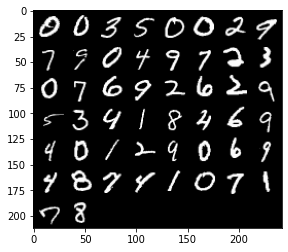

In [24]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
  
# show images
imshow(torchvision.utils.make_grid(images))

In [35]:
# parameters 
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 20

In [36]:
class RNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(RNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [37]:
model = RNN(batch_sizes, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[-0.0648, -0.1898, -0.0871,  0.0106,  0.0343, -0.0238, -0.0055, -0.0754,
         -0.0421, -0.0284],
        [-0.0568, -0.2071, -0.0871,  0.0122,  0.0286, -0.0167, -0.0139, -0.0780,
         -0.0536, -0.0323],
        [-0.0639, -0.1814, -0.0853,  0.0063,  0.0238, -0.0371, -0.0042, -0.0782,
         -0.0490, -0.0359],
        [-0.0602, -0.1936, -0.0849,  0.0087,  0.0325, -0.0199, -0.0080, -0.0728,
         -0.0488, -0.0338],
        [-0.0495, -0.1994, -0.0712,  0.0183,  0.0303, -0.0317, -0.0076, -0.0641,
         -0.0498, -0.0279],
        [-0.0566, -0.2012, -0.0863,  0.0091,  0.0274, -0.0201, -0.0156, -0.0807,
         -0.0505, -0.0334],
        [-0.0574, -0.2060, -0.0894,  0.0156,  0.0264, -0.0199, -0.0081, -0.0746,
         -0.0517, -0.0320],
        [-0.0545, -0.2380, -0.0654,  0.0187,  0.0515, -0.0138,  0.0077, -0.0598,
         -0.0554, -0.0037],
        [-0.0738, -0.1706, -0.0974,  0.0487,  0.0448, -0.0165, -0.0387, -0.0948,
         -0.0757, -0.0089],
        [-0.0467, -

In [38]:
# construct model on cuda if available

use_cuda = torch.cuda.is_available()


# Model instance
model = RNN(batch_sizes, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [39]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(train_loader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, batch_sizes)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.6297 | Train Accuracy: 79.93
Epoch:  1 | Loss: 0.2855 | Train Accuracy: 91.68
Epoch:  2 | Loss: 0.2269 | Train Accuracy: 93.52
Epoch:  3 | Loss: 0.1882 | Train Accuracy: 94.63
Epoch:  4 | Loss: 0.1594 | Train Accuracy: 95.59
Epoch:  5 | Loss: 0.1485 | Train Accuracy: 95.82
Epoch:  6 | Loss: 0.1414 | Train Accuracy: 96.09
Epoch:  7 | Loss: 0.1292 | Train Accuracy: 96.38
Epoch:  8 | Loss: 0.1250 | Train Accuracy: 96.49
Epoch:  9 | Loss: 0.1213 | Train Accuracy: 96.63
Epoch:  10 | Loss: 0.1113 | Train Accuracy: 96.96
Epoch:  11 | Loss: 0.1183 | Train Accuracy: 96.72
Epoch:  12 | Loss: 0.1077 | Train Accuracy: 96.99
Epoch:  13 | Loss: 0.1097 | Train Accuracy: 96.98
Epoch:  14 | Loss: 0.1035 | Train Accuracy: 97.17
Epoch:  15 | Loss: 0.1073 | Train Accuracy: 97.08
Epoch:  16 | Loss: 0.1045 | Train Accuracy: 97.05
Epoch:  17 | Loss: 0.1212 | Train Accuracy: 96.62
Epoch:  18 | Loss: 0.0977 | Train Accuracy: 97.34
Epoch:  19 | Loss: 0.0990 | Train Accuracy: 97.29


In [40]:
val_acc = 0.0
for i, data in enumerate(val_loader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    val_acc += get_accuracy(outputs, labels, batch_sizes)
        
print('Val Accuracy: %.2f'%(val_acc/i))

Val Accuracy: 96.65
